In [1]:
import numpy as np
import matplotlib.pyplot as plt

Decisions that I made:
* Periodic BCs. This is not a user choice.
* Simulation grid is a square
* Can have multiple species of particles (perhaps want to keep track of different populations, etc)
* There is a single Simulator object which stores the grid as well as the particles associated with the simulation.  The user can also create their own `Particles` and `Grid` objects outside of the main Simulator to work with

# Global simulation parameters

In [2]:
SIMULATION_PARAMETERS = {
    'DOMAIN_SIZE': 1.0,
    'GRID_SIZE': 0.1,
    'TIME_STEPS': 0 # How many time steps has the simulator evolved through
}

PARTICLE_SPECIES = {
    'N': 0, # The total number of particle species in the simulator
    'PARTICLES_PER_SPECIES': [], # How many particles are in each species
    'SPECIES_LIST': [], # Pointers to the Particle objects
}

# Classes

In [3]:
class PMSimulator:
    def __init__(self):
        
        self.grid = Grid(SIMULATION_PARAMETERS['DOMAIN_SIZE'], SIMULATION_PARAMETERS['GRID_SIZE']) # Create the simulation grid

    def create_particles(self, num_particles, species_name=None):
        particles_instance = Particles(num_particles)
        if species_name is None:
            # Assign generic attribute name if none is passed by user
            species_name = f'particles_{len([attr for attr in self.__dict__ if "particles_" in attr])}'
            
        setattr(self, species_name, particles_instance)
        
        PARTICLE_SPECIES['N'] += 1
        PARTICLE_SPECIES['PARTICLES_PER_SPECIES'].append(num_particles)
        PARTICLE_SPECIES['SPECIES_LIST'].append(getattr(self, species_name))

    def reset_all(self):
        '''
        Delete all particle attributes and reset the simulation grid according to current values of SIMULATION_PARAMETERS
        Update PARTICLE_SPECIES accordingly
        '''
        # Delete particle attributes
        for attr in list(self.__dict__):
            if attr != 'grid':
                delattr(self, attr)
    
        # Reset the simulation grid
        self.grid = Grid(SIMULATION_PARAMETERS['DOMAIN_SIZE'], SIMULATION_PARAMETERS['GRID_SIZE'])

        # Reset particle species information
        PARTICLE_SPECIES['N'] = 0
        PARTICLE_SPECIES['PARTICLES_PER_SPECIES'] = []
        PARTICLE_SPECIES['SPECIES_LIST'] = []

In [4]:
class Particles:
    
    def __init__(self, num_particles, species_name=None):
        
        if not isinstance(num_particles, int):
            raise TypeError("num_particles must be an integer.")
            
        self.num_particles = num_particles
        self.x_positions = ParticleArray(num_particles)
        self.y_positions = ParticleArray(num_particles)
        self.x_velocities = ParticleArray(num_particles)
        self.y_velocities = ParticleArray(num_particles)
        self.masses = ParticleArray(num_particles)

    def apply_periodic_bc(self):
        '''
        Apply periodic boundary conditions for positions arrays
        '''
        self.x_positions.data = self.x_positions.data % SIMULATION_PARAMETERS['DOMAIN_SIZE']
        self.y_positions.data = self.y_positions.data % SIMULATION_PARAMETERS['DOMAIN_SIZE']

    def kinetic_energy(self):
        '''
        Calculate and return the kinetic energy of particle species in current state
        '''
        v_squared = self.x_velocities.data**2 + self.y_velocities.data**2

        return 0.5 * np.sum( self.masses.data * v_squared )

In [5]:
class ParticleArray:

    ALLOWED_DISTRIBUTIONS = ['uniform', 'normal', 'allones']
        
    def __init__(self, num_particles):
        if not isinstance(num_particles, int):
            raise TypeError("num_particles must be an integer.")
        
        self.num_particles = num_particles
        self.data = np.zeros(num_particles, dtype='float64')

    def initialize_uniform(self, bounds=(0, 1)):
        self.data = np.random.uniform(low=bounds[0], high=bounds[1], size=self.num_particles)

    def initialize_normal(self, mean=0, std=1):
        self.data = np.random.normal(mean, std, self.num_particles)

    def initialize_all_ones(self, scale=1.0):
        self.data = scale * np.ones(self.num_particles)

    def initialize(self, distribution='uniform', **kwargs):
        '''
        Method to initialize an array according to some specifies distribution

        Inputs:
        distribution - the distribution according which to intialize the array.  Must be from ALLOWED_DISTRIBUTIONS
            'uniform': a uniform distribution, range specified by the tuple 'bounds'
            'normal': a Gaussian distribution, mean and std can be specified by the user
            'allones': set all entries to a single value, specified by the float 'scale'
        
        Returns:
        None
        '''
        if distribution not in self.ALLOWED_DISTRIBUTIONS:
            raise ValueError(f"Invalid distribution type. Allowed distributions: {', '.join(self.ALLOWED_DISTRIBUTIONS)}")

        # Initialize according to chosen distribution
        if distribution == 'uniform':
            self.initialize_uniform(**kwargs)
        elif distribution == 'normal':
            self.initialize_normal(**kwargs)
        elif distribution == 'allones':
            self.initialize_all_ones(**kwargs)

In [6]:
class Grid:

    DENSITY_METHODS = ['tsc', 'cic', 'ngp']
    
    def __init__(self, domain_size, grid_size):
        
        # Number of grid cells along each axis
        self.grid_cells_x = int(domain_size / grid_size)
        self.grid_cells_y = int(domain_size / grid_size)

        # Initialize the density field to zero
        self.denisty_field = np.zeros((self.grid_cells_x, self.grid_cells_y))

    def assign_density(self, particle_populations, method='tsc'):
        '''
        Assign a grid density based on the particles on the grid

        Inputs:
        particle_populations - an instantiation of Particles, or a list of instantiations, representing the particles on the grid
        method - the density assignment method.  Default is TSC

        Returns:
        None
        '''
        
        if method not in self.DENSITY_METHODS:
            raise ValueError(f"Invalid density assignment method. Allowed methods: {', '.join(self.DENSITY_METHODS)}")

        # Ensure particle_populations is a list
        if not isinstance(particle_populations, list):
            particle_populations = [particle_populations]

        # Assign density to each grid cell
        for particles in particle_populations:    
            for x, y, mass in zip(particles.x_positions.data, 
                                  particles.y_positions.data, 
                                  particles.masses.data):
                if method == 'tsc':
                    self.assign_density_tsc(x, y, mass)
                elif method == 'cic':
                    self.assign_density_cic(x, y, mass)
                elif method == 'ngp':
                    self.assign_density_ngp(x, y, mass)
    
    def assign_density_tsc(self, x, y, mass):
        '''
        Triangular Shaped Cloud (TSC) scheme for applying density to grid cells

        Inputs:
        x - x particle positions
        y - y particle positions
        mass - mass of each particle

        Returns:
        None
        '''
        # Convert particle positions to grid indices
        grid_x = int(x / SIMULATION_PARAMETERS['GRID_SIZE'])
        grid_y = int(y / SIMULATION_PARAMETERS['GRID_SIZE'])
        
        # Loop over the 3x3 grid around the particle's grid cell
        for i in range(grid_x - 1, grid_x + 2):
            for j in range(grid_y - 1, grid_y + 2):
                # Apply periodic boundary conditions to grid indices
                i_periodic = i % self.grid_cells_x
                j_periodic = j % self.grid_cells_y

                # Distance between particle and grid cell center
                dx = (i_periodic + 0.5) * SIMULATION_PARAMETERS['GRID_SIZE'] - x
                dy = (j_periodic + 0.5) * SIMULATION_PARAMETERS['GRID_SIZE'] - y
                    
                # TSC weights along x and y directions
                weight_x = max(1 - abs(2 * dx / SIMULATION_PARAMETERS['GRID_SIZE']), 0)
                weight_y = max(1 - abs(2 * dy / SIMULATION_PARAMETERS['GRID_SIZE']), 0)

                weight = weight_x * weight_y

                self.denisty_field[j_periodic, i_periodic] += mass * weight

    def assign_density_cic(self, grid_x, grid_y, x, y, mass):
        '''
        Cloud in Cell (CIC) scheme for applying density to grid cells
        '''
        
        # CIC density assignment logic
        # ... (implementation needed)
        
    def assign_density_ngp(self, grid_x, grid_y, x, y, mass):
        '''
        Nearest Grid Point (NGP) scheme for applying density to grid cells
        '''
        # NGP density assignment logic
        # ... (implementation needed)

    def plot_density_heatmap(self, particles=None, **kwargs):
        '''
        Method to plot the current grid density as a heatmap.
        Note that the only kwargs that will get noticed are:
        -cmap for the heatmap
        -c, maker, s, and alpha for the scatter
    
        Parameters:
        particles - particles to overlay on the heatmap. Can be a list. Default is None.
    
        Returns:
        None
        '''
        plt.figure(figsize=(8, 8))
    
        # Plot the grid density as a heatmap
        heatmap_kwargs = {
            'cmap': kwargs.get('cmap', 'viridis'),
            'origin': 'lower',
            'extent': [0, SIMULATION_PARAMETERS['DOMAIN_SIZE'], 0, SIMULATION_PARAMETERS['DOMAIN_SIZE']]
        }
        heatmap = plt.imshow(self.denisty_field, **heatmap_kwargs)
    
        # Overlay particle positions if provided
        if particles is not None:
            # Ensure particles is a list
            if not isinstance(particles, list):
                particles = [particles]

            for i, particle_pop in enumerate(particles):
                scatter_kwargs = {
                    'marker': kwargs.get('marker', 'o'),
                    's': kwargs.get('s', 2),
                    'alpha': kwargs.get('alpha', 0.5),
                    'label': f'Particles {i + 1}'
                }
                plt.scatter(
                    particle_pop.x_positions.data, particle_pop.y_positions.data, **scatter_kwargs
                )
            plt.legend()
    
        colorbar = plt.colorbar(heatmap, label='Density')

        # Cosmetics
        plt.title('Grid Density Heatmap')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.xlim(0, SIMULATION_PARAMETERS['DOMAIN_SIZE'])
        plt.ylim(0, SIMULATION_PARAMETERS['DOMAIN_SIZE'])
    
        plt.show()

# Testing

In [7]:
# Set some SIMULATION_PARAMETERS
SIMULATION_PARAMETERS['GRID_SIZE'] = 0.05

# Create a PMSimulator object based on current simulation parameters
simulator = PMSimulator()

# Create 2 species of particles
simulator.create_particles(1000)
simulator.create_particles(500)

# Store in variables for easy access
parts1 = simulator.particles_0
parts2 = simulator.particles_1

In [8]:
# Initialize attributes of the particle species
parts1.x_positions.initialize(distribution='normal', mean=0.2, std=0.2)
parts1.y_positions.initialize(distribution='normal', mean=0.8, std=0.2)
parts1.masses.initialize(distribution='allones')
parts1.apply_periodic_bc()

parts2.x_positions.initialize(distribution='uniform', bounds=(0.2, 0.8))
parts2.y_positions.initialize(distribution='normal', mean=0.5, std=0.1)
parts2.masses.initialize(distribution='allones')
parts2.apply_periodic_bc()

In [9]:
# Calculate the density field
simulator.grid.assign_density([parts1, parts2])

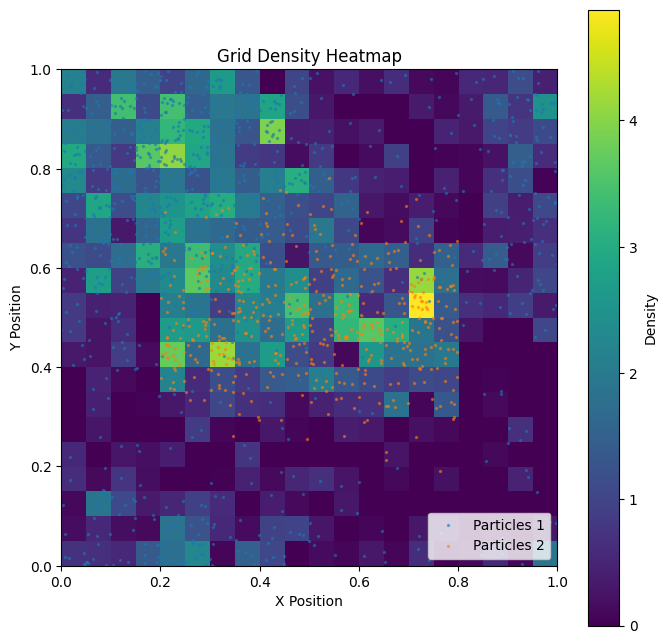

In [10]:
# Plot the density field, with the option of showing particles overlaid on top
simulator.grid.plot_density_heatmap(particles=[parts1, parts2])